In [28]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
from data_utils import load_metadata, sample_sounds_by_category, load_wave_data, load_all_sounds
from plot_utils import visualize_category_sounds,create_histogram_subplot
from feature_utils import compute_features_for_wave_list, compute_combined_features_for_wave_list, save_features_to_npz, save_multiple_features_to_npz
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

In [2]:
# 1) Specify paths
csv_file_path = "datasets/ESC-50-master/meta/esc50.csv"
audio_files_path = "datasets/ESC-50-master/audio/"

# 1.1) check if the paths exist
assert os.path.exists(csv_file_path), "CSV file not found!"
assert os.path.exists(audio_files_path), "Audio directory not found!"


In [3]:
# 2) Load metadata
df = load_metadata(csv_file_path)

print(df)
print("Missing values:\n", df.isnull().sum()) # Check for missing values
print(df.describe()) # Show summary statistics

               filename  fold  target        category  esc10  src_file take
0      1-100032-A-0.wav     1       0             dog   True    100032    A
1     1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2     1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3     1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4     1-101296-A-19.wav     1      19    thunderstorm  False    101296    A
...                 ...   ...     ...             ...    ...       ...  ...
1995   5-263831-B-6.wav     5       6             hen  False    263831    B
1996  5-263902-A-36.wav     5      36  vacuum_cleaner  False    263902    A
1997   5-51149-A-25.wav     5      25       footsteps  False     51149    A
1998    5-61635-A-8.wav     5       8           sheep  False     61635    A
1999     5-9032-A-0.wav     5       0             dog   True      9032    A

[2000 rows x 7 columns]
Missing values:
 filename    0
fold        0
target      0
cate

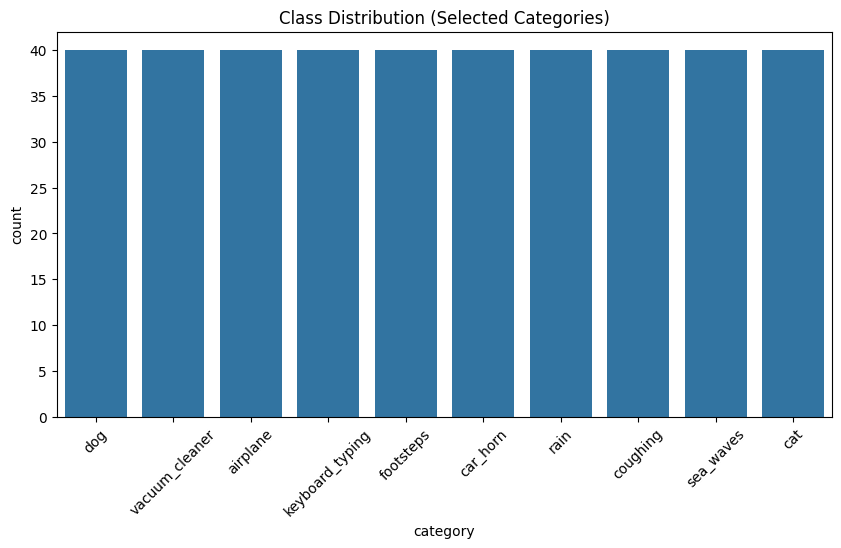

In [4]:
# 3) Define categories
categories = {
        'Animals': ['dog', 'cat'],
        'Natural soundscapes & water sounds': ['rain', 'sea_waves'],
        'Human sounds': ['coughing', 'footsteps'],
        'Interior/domestic sounds': ['keyboard_typing', 'vacuum_cleaner'],
        'Exterior/urban noises': ['airplane', 'car_horn']
    }
# Filter the dataframe to only include selected categories
selected_classes = sum(categories.values(), [])  # Flatten the dictionary into a list of class names
df_filtered = df[df['category'].isin(selected_classes)]  # Keep only selected categories

# Plot class distribution of selected categories
plt.figure(figsize=(10, 5))
sns.countplot(x=df_filtered['category'])
plt.xticks(rotation=45)
plt.title("Class Distribution (Selected Categories)")
plt.show()

In [5]:
# 4) Sample sounds
sampled_sounds = sample_sounds_by_category(df, categories)

# Track missing and represented classes
missing_classes = {}
represented_classes = {}

for category, expected_classes in categories.items():
    # Extract actual classes from sampled sounds
    sampled_classes = set(df[df['filename'].isin(sampled_sounds[category])]['category'])
    
    # Check which classes are missing
    missing = set(expected_classes) - sampled_classes
    represented_classes[category] = sampled_classes

    if missing:
        missing_classes[category] = missing

    print(f"Category: {category}, Sampled Classes: {sampled_classes}")

# Summary
print("\n✅ Represented Classes:")
for category, classes in represented_classes.items():
    print(f"- {category}: {classes}")

if missing_classes:
    print("\n❌ Missing Classes:")
    for category, classes in missing_classes.items():
        print(f"- {category}: {classes}")
else:
    print("\n🎉 All expected classes are present!")


Category: Animals, Sampled Classes: {'cat', 'dog'}
Category: Natural soundscapes & water sounds, Sampled Classes: {'rain', 'sea_waves'}
Category: Human sounds, Sampled Classes: {'coughing', 'footsteps'}
Category: Interior/domestic sounds, Sampled Classes: {'keyboard_typing', 'vacuum_cleaner'}
Category: Exterior/urban noises, Sampled Classes: {'airplane', 'car_horn'}

✅ Represented Classes:
- Animals: {'cat', 'dog'}
- Natural soundscapes & water sounds: {'rain', 'sea_waves'}
- Human sounds: {'coughing', 'footsteps'}
- Interior/domestic sounds: {'keyboard_typing', 'vacuum_cleaner'}
- Exterior/urban noises: {'airplane', 'car_horn'}

🎉 All expected classes are present!


In [6]:
# 5) Load wave data
wave_list_data_sampled = load_wave_data(sampled_sounds, audio_files_path) #load_sample
wave_list_data = load_all_sounds(df, categories, audio_files_path) #load all sounds

print("Total samples loaded:", len(wave_list_data))
print("Example sample rate:", wave_list_data[0][2])
print("Example waveform shape:", wave_list_data[0][3].shape)

Total samples loaded: 400
Example sample rate: 44100
Example waveform shape: (220500,)


Analyzing Animals category...


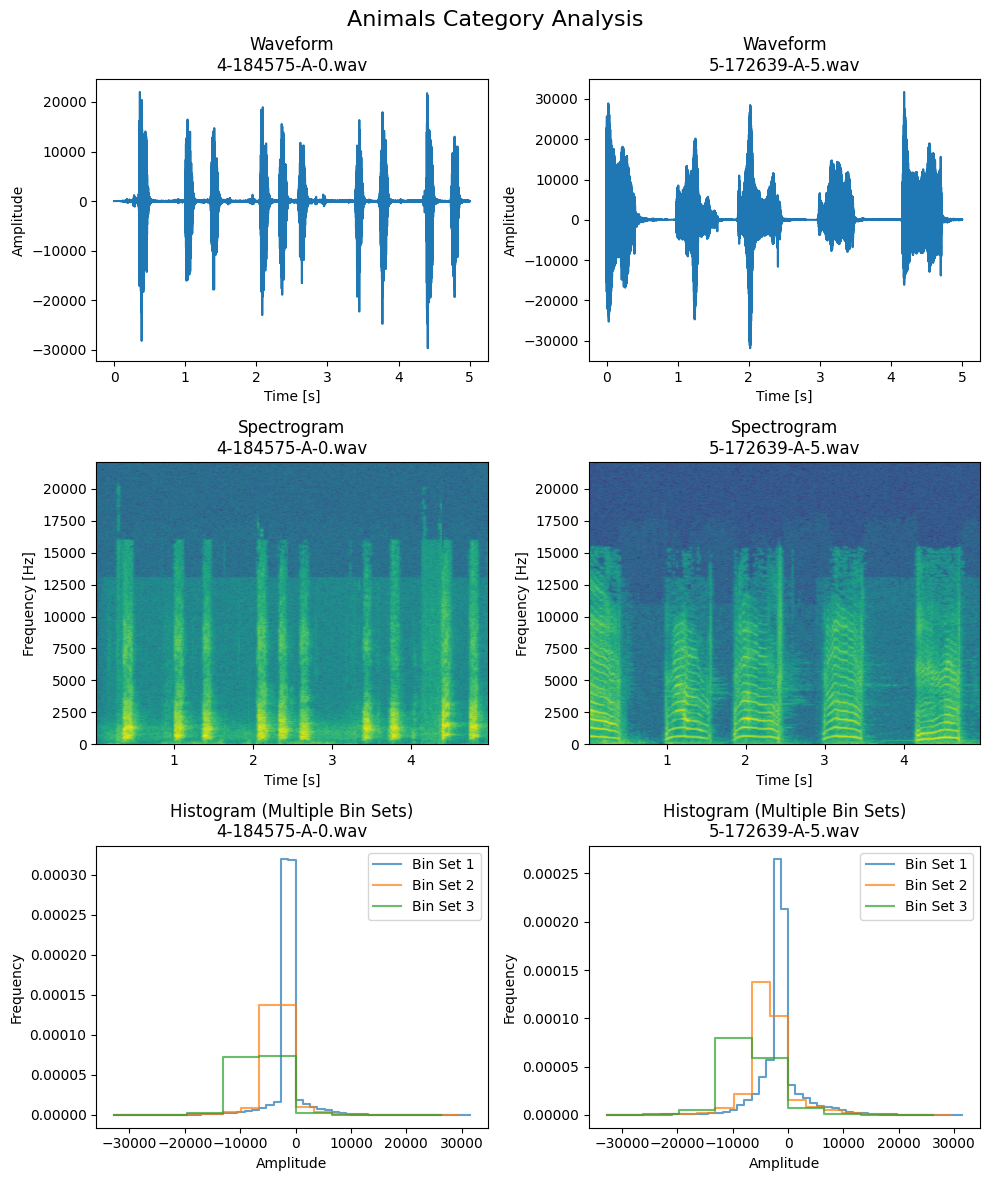

Analyzing Natural soundscapes & water sounds category...


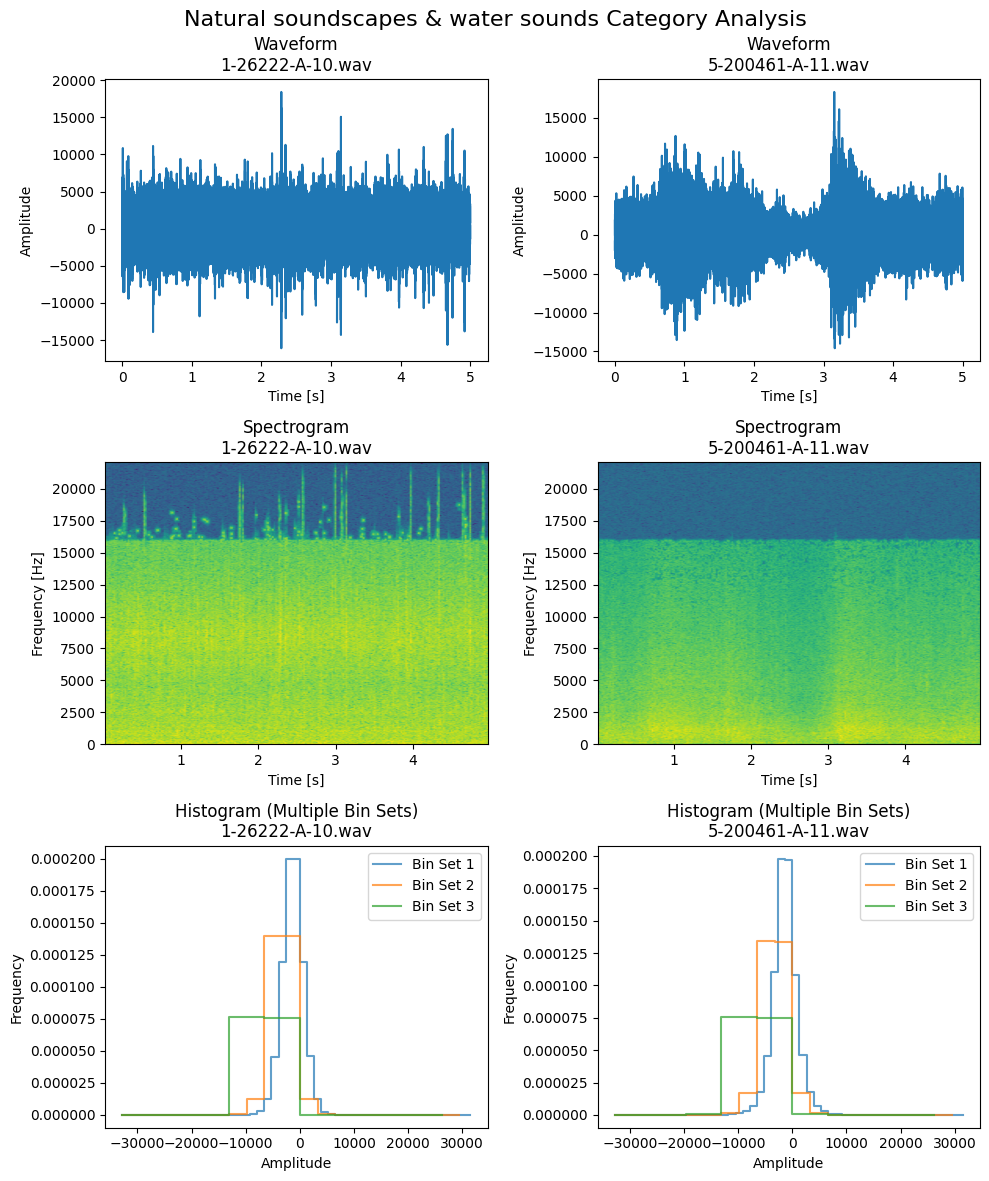

Analyzing Human sounds category...


/Users/minaghaderi/Documents/AML/AML-Soheil-Mina-Amir/plot_utils.py:50: RuntimeWarning: divide by zero encountered in log10
  im = ax.pcolormesh(t, f, 20 * np.log10(Sxx), shading='gouraud')


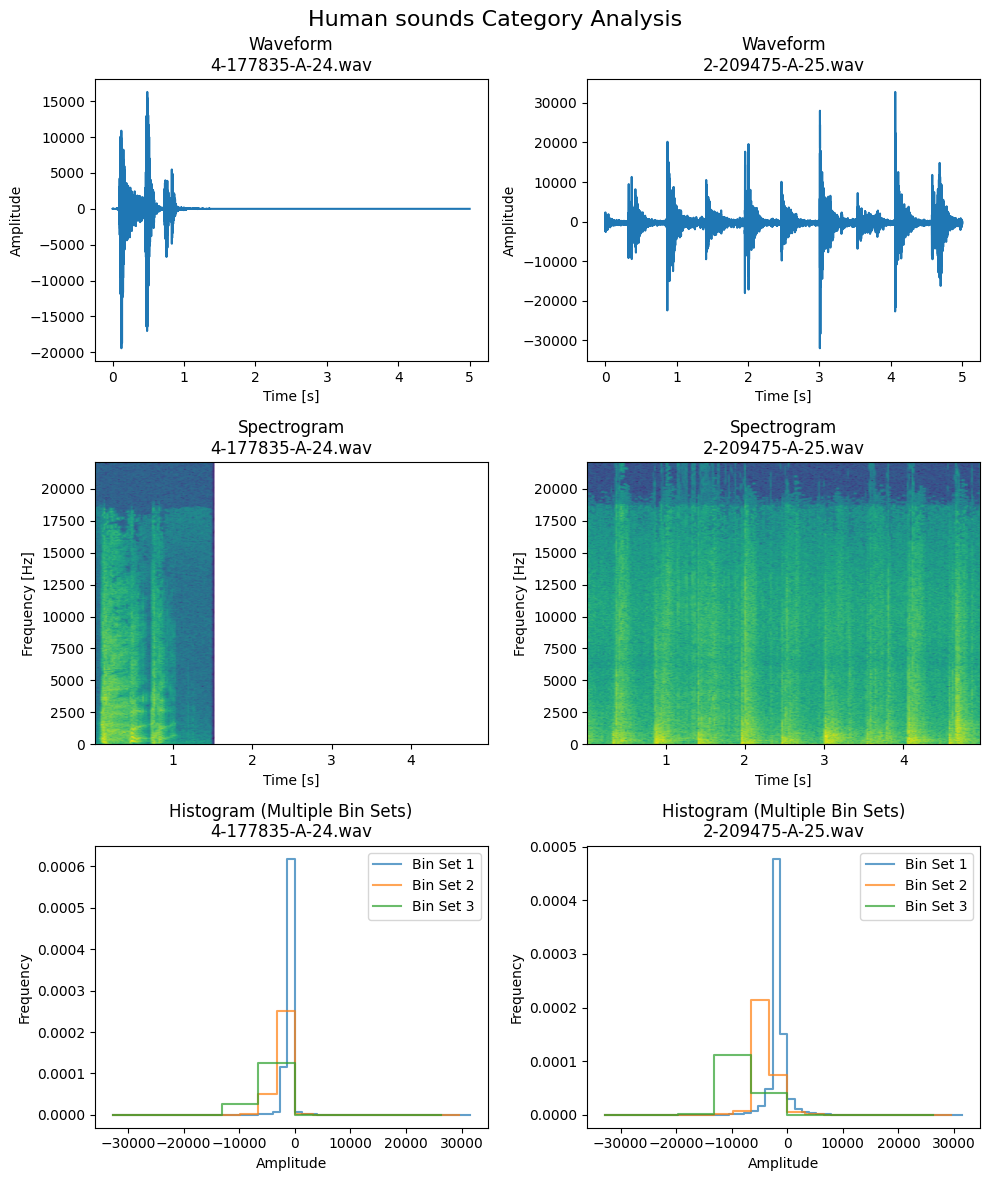

Analyzing Interior/domestic sounds category...


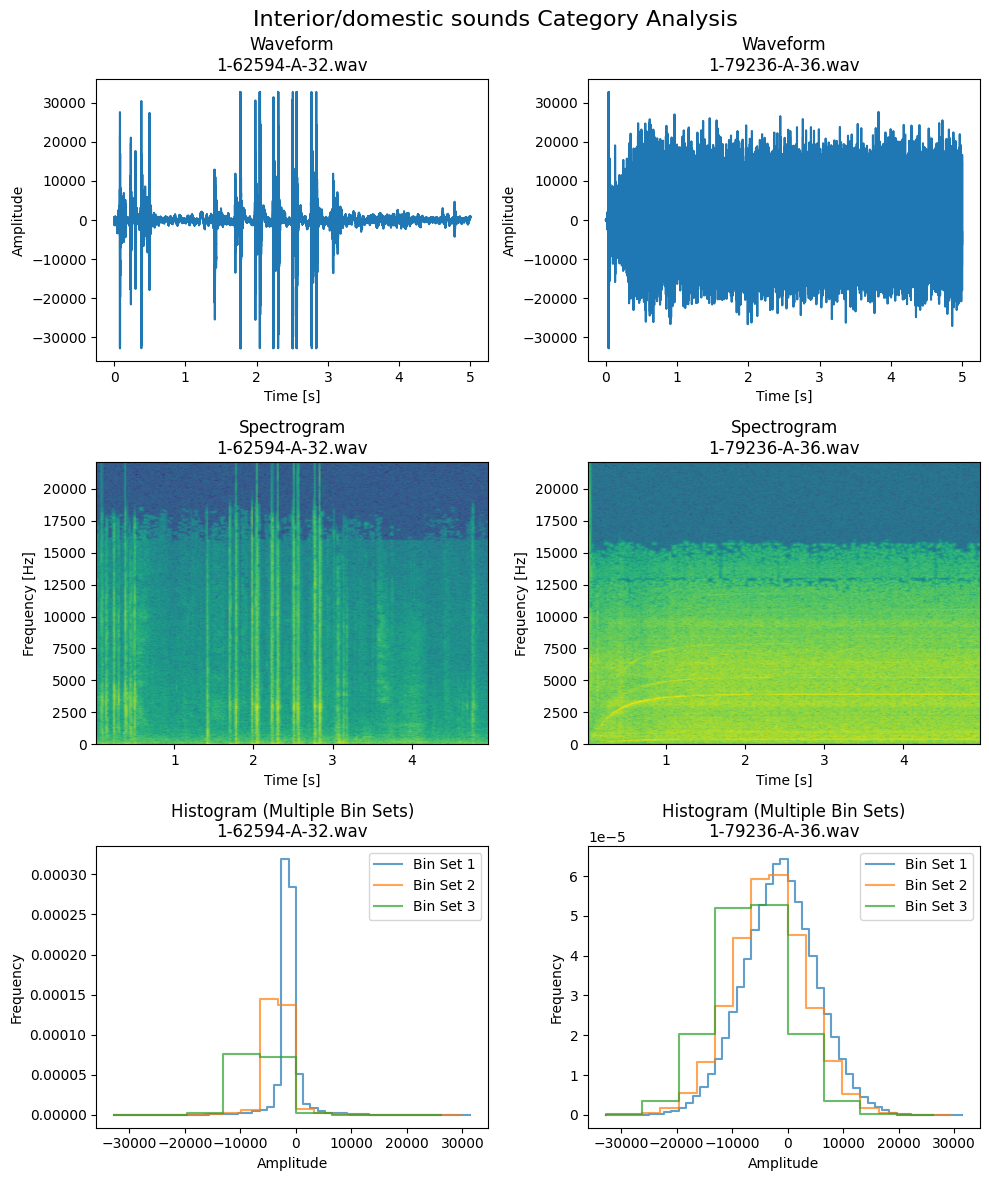

Analyzing Exterior/urban noises category...


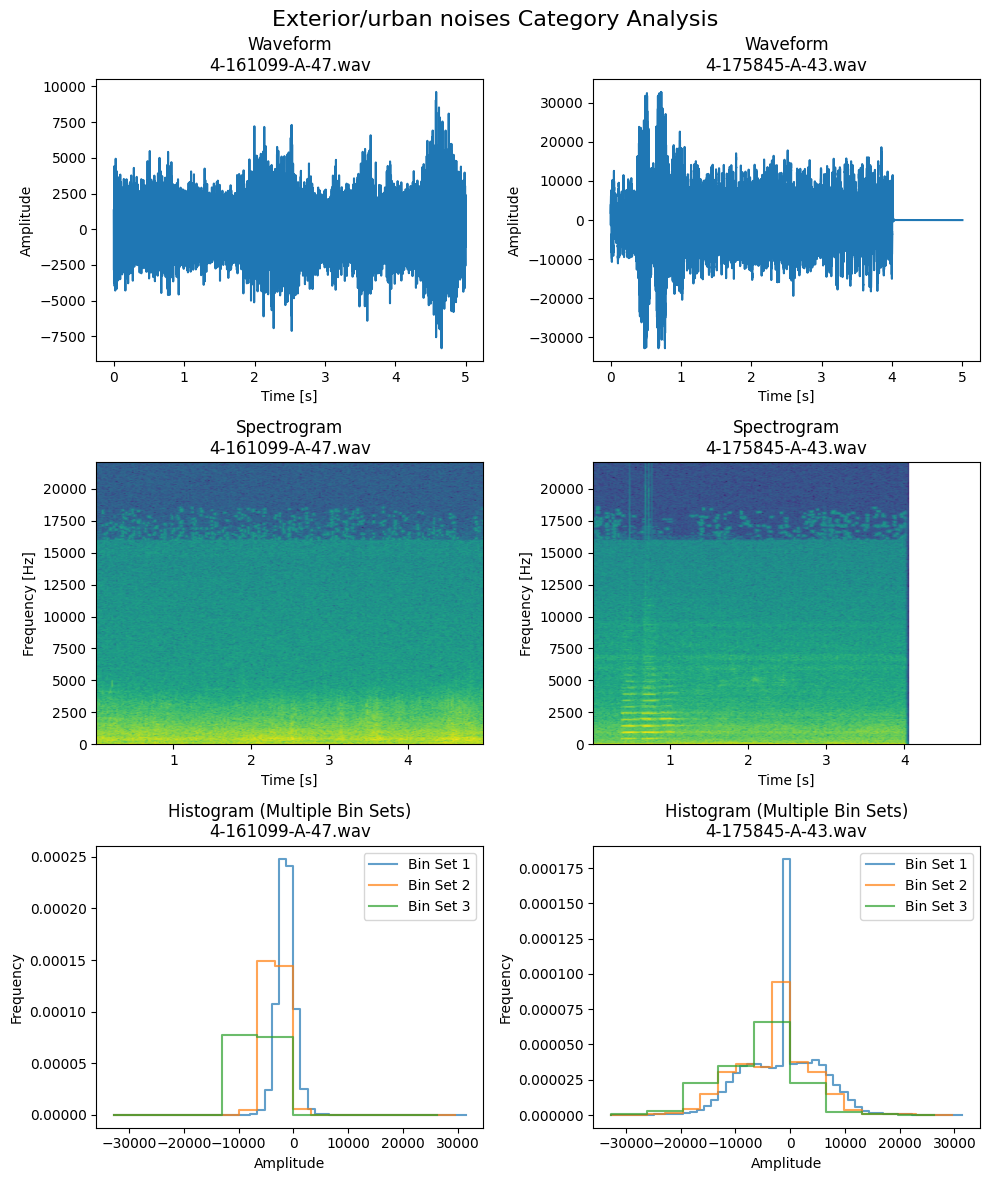

{'Animals': [{'bins_set_1': array([0.00000000e+00, 0.00000000e+00, 6.92019134e-09, 1.03802870e-08,
          1.73004783e-08, 6.92019134e-09, 2.76807653e-08, 3.46009567e-08,
          4.49812437e-08, 6.22817220e-08, 1.52244209e-07, 2.73347558e-07,
          3.80610524e-07, 5.63995594e-07, 9.23845543e-07, 1.20065320e-06,
          1.76118870e-06, 2.52932993e-06, 3.24556974e-06, 4.53272533e-06,
          6.30083421e-06, 9.17617371e-06, 1.19027291e-05, 1.67088020e-05,
          3.20020788e-04, 3.18411844e-04, 1.83661878e-05, 1.37054389e-05,
          1.00065967e-05, 7.39076435e-06, 5.55691364e-06, 3.60195959e-06,
          2.43936745e-06, 1.55012286e-06, 8.26962865e-07, 5.39774924e-07,
          2.42206697e-07, 1.66084592e-07, 1.34943731e-07, 5.88216264e-08,
          3.11408610e-08, 3.80610524e-08, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00, 0.00000000e+00]),
   'bins_set_2': array([1.38403827e-09, 1.2

In [ ]:
# 6) Visualize
visualize_category_sounds(wave_list_data_sampled)

In [8]:
# 7) Extract all features
keys_list, combined_features = compute_combined_features_for_wave_list(wave_list_data)

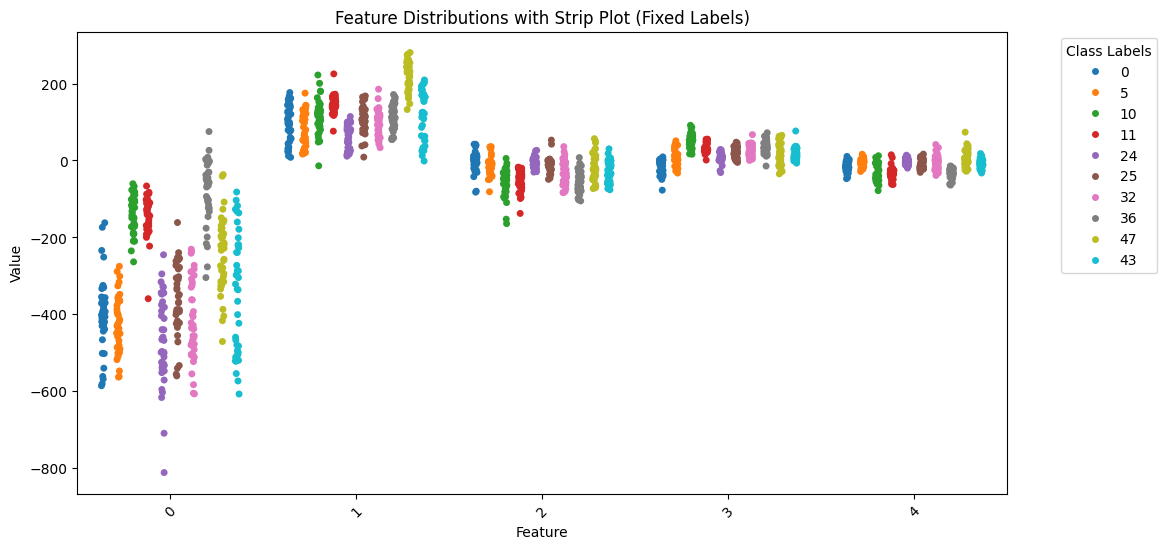

In [9]:
### Compare feature distributions for different classes

# Convert combined_features to DataFrame
df_features = pd.DataFrame(combined_features)
df_features["label"] = keys_list  # Add class labels

# Ensure labels are categorical, not just numbers
df_features["label"] = df_features["label"].astype(str)  # Convert to string labels

# Select first 5 features for visualization (modify if needed)
selected_features = df_features.iloc[:, :5]  
selected_features["label"] = df_features["label"]  # Re-add labels

# Convert to long format for plotting
df_melted = selected_features.melt(id_vars="label", var_name="Feature", value_name="Value")

# --- Strip Plot Fix ---
plt.figure(figsize=(12, 6))
sns.stripplot(x="Feature", y="Value", hue="label", data=df_melted, dodge=True, jitter=True)
plt.title("Feature Distributions with Strip Plot (Fixed Labels)")
plt.xticks(rotation=45)
plt.legend(title="Class Labels", bbox_to_anchor=(1.05, 1), loc='upper left')  # Fix legend
plt.show()



In [10]:
# 8) Save all features
save_features_to_npz(keys_list, combined_features, out_file="features/extracted_features_test.npz")

# Check file integrity after saving
loaded_data = np.load("features/extracted_features_test.npz")
print("Loaded feature shape:", loaded_data['features'].shape)
print("Keys shape:", loaded_data['keys'].shape)

Features saved to features/extracted_features_test.npz
Loaded feature shape: (400, 126)
Keys shape: (400,)


In [11]:
# 7) Extract selected features
keys_list, mfcc_list, hist_list, spectral_list = compute_features_for_wave_list(wave_list_data)

# 8) Save selected features
save_multiple_features_to_npz(keys_list, mfcc_list, hist_list, spectral_list, out_file="features/extracted_features_multiple_test.npz")

loaded_data = np.load("features/extracted_features_multiple_test.npz")
print("Stored arrays:", loaded_data.files)

print("Keys shape:", loaded_data['keys'].shape)
print("MFCC shape:", loaded_data['mfcc'].shape)
print("Histogram shape:", loaded_data['hist'].shape)
print("Spectral shape:", loaded_data['spectral'].shape)

#print("First MFCC feature vector:", loaded_data['mfcc'][0])
#print("First histogram feature vector:", loaded_data['hist'][0])
#print("First spectral feature vector:", loaded_data['spectral'][0])


Multiple features saved to features/extracted_features_multiple_test.npz
Stored arrays: ['keys', 'mfcc', 'hist', 'spectral']
Keys shape: (400,)
MFCC shape: (400, 26)
Histogram shape: (400, 80)
Spectral shape: (400, 20)


In [12]:
# Extract features and labels
keys_list = loaded_data['keys']
mfcc_features = loaded_data['mfcc']
hist_features = loaded_data['hist']
spectral_features = loaded_data['spectral']

combined_features = np.hstack([mfcc_features, hist_features, spectral_features])

In [19]:
# Train-Test Splitting
X = combined_features
y = np.array(keys_list)  # Ensure y is a NumPy array

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Split into training and testing sets

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

# Debugging: Check which classes exist in keys_list before splitting
unique_classes = set(keys_list)
print("Unique classes in dataset before splitting:", unique_classes)

# Count occurrences of each class in train and test sets
train_counts = pd.Series(y_train).value_counts().sort_index()
test_counts = pd.Series(y_test).value_counts().sort_index()

# Print class counts
print("Training Class Counts:\n", train_counts)
print("\nTest Class Counts:\n", test_counts)

Training set size: (320, 126)
Test set size: (80, 126)
Unique classes in dataset before splitting: {0, 32, 36, 5, 10, 11, 43, 47, 24, 25}
Training Class Counts:
 0     30
5     28
10    31
11    32
24    35
25    33
32    32
36    37
43    28
47    34
Name: count, dtype: int64

Test Class Counts:
 0     10
5     12
10     9
11     8
24     5
25     7
32     8
36     3
43    12
47     6
Name: count, dtype: int64


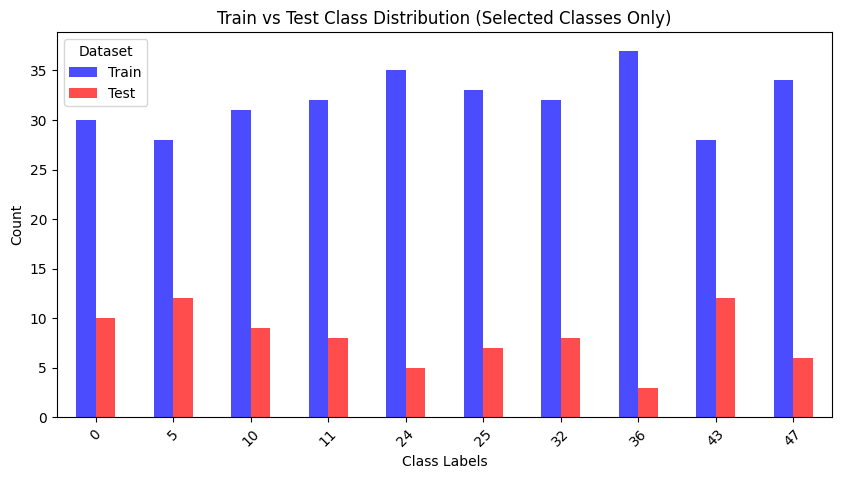

In [ ]:
# Convert lists to Pandas Series for counting
train_counts = pd.Series(y_train).value_counts()
test_counts = pd.Series(y_test).value_counts()

# Merge train and test counts into a single DataFrame
df_counts = pd.DataFrame({'Train': train_counts, 'Test': test_counts}).fillna(0)

# Plot bar chart for class distributions
df_counts.plot(kind="bar", figsize=(10, 5), color=["blue", "red"], alpha=0.7)
plt.xlabel("Class Labels")
plt.ylabel("Count")
plt.title("Train vs Test Class Distribution (Selected Classes Only)")
plt.xticks(rotation=45)
plt.legend(title="Dataset")
plt.show()


In [21]:
# Define Stratified K-Fold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Reasonable range of C values
    'gamma': [0.01, 0.1, 1, 'scale', 10, 100],  # Includes 'scale'
    'kernel': ['rbf']  # Using only RBF kernel
}

# Perform GridSearch with Stratified K-Fold
grid_search = GridSearchCV(SVC(), param_grid, cv=kfold, verbose=2, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Print best hyperparameters
print("Best parameters:", grid_search.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END .....................C=0.01, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.01, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.01, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.01, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.01, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.01, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.01, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.01, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.01, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.01, gamma=

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.70      0.58        10
           5       0.40      0.33      0.36        12
          10       0.78      0.78      0.78         9
          11       0.56      0.62      0.59         8
          24       0.08      0.20      0.11         5
          25       0.43      0.43      0.43         7
          32       0.50      0.38      0.43         8
          36       0.60      1.00      0.75         3
          43       1.00      0.08      0.15        12
          47       0.67      0.67      0.67         6

    accuracy                           0.47        80
   macro avg       0.55      0.52      0.49        80
weighted avg       0.58      0.47      0.46        80



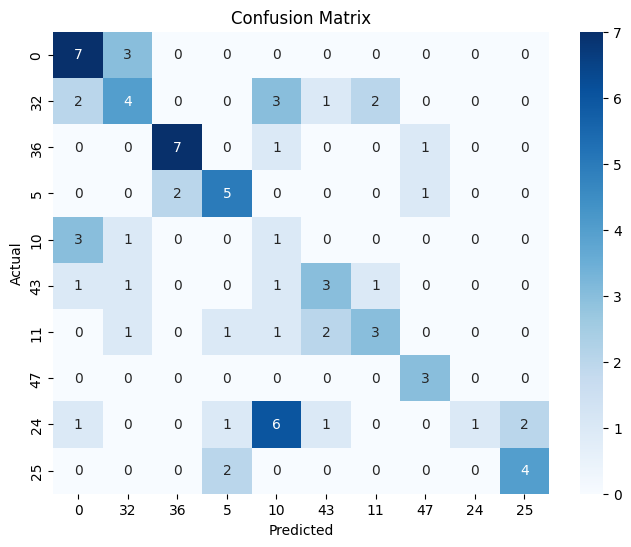

In [23]:
# Initialize the SVM classifier
svm = SVC(kernel='rbf', C=100, gamma='scale', random_state=42)

# Train the SVM classifier
svm.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm.predict(X_test)

# Evaluate performance
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_train), yticklabels=set(y_train))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1180: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1180: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1180: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1180: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1180: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packa

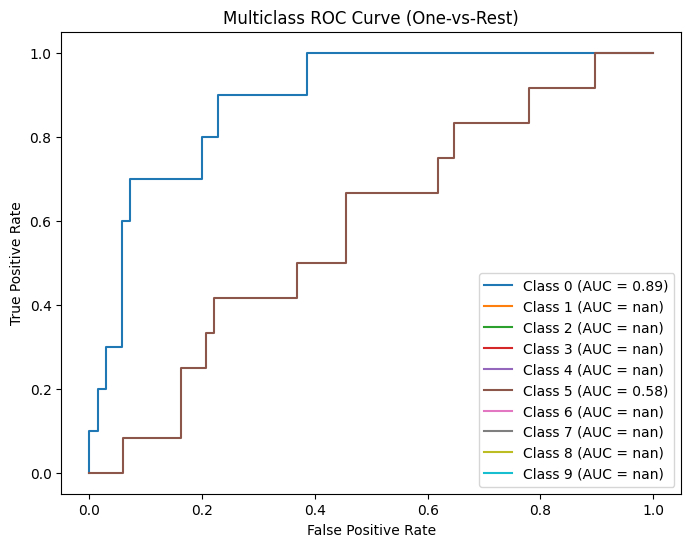

In [24]:
# Get decision function scores
y_scores = svm.decision_function(X_test)

num_classes = y_scores.shape[1]  # Number of classes

plt.figure(figsize=(8, 6))

for class_idx in range(num_classes):
    # Convert multi-class labels into binary (One vs. Rest)
    y_test_binary = (y_test == class_idx).astype(int)

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test_binary, y_scores[:, class_idx])
    roc_auc = auc(fpr, tpr)

    # Plot each class's ROC curve
    plt.plot(fpr, tpr, label=f"Class {class_idx} (AUC = {roc_auc:.2f})")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("Multiclass ROC Curve (One-vs-Rest)")
plt.show()


In [25]:
# Reduce features to 10 dimensions using PCA
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Reduced feature shape:", X_train_pca.shape)

Explained variance ratio: [8.19968433e-01 1.25149946e-01 4.60601267e-02 4.19050592e-03
 3.62290938e-03 5.00092405e-04 1.46175525e-04 1.09488903e-04
 9.99018934e-05 3.49309494e-05]
Reduced feature shape: (320, 10)


In [26]:
vm = SVC(kernel='rbf', C=100, gamma='scale', random_state=42)
svm.fit(X_train_pca, y_train)

# Predict on the test set
y_pred = svm.predict(X_test_pca)

# Evaluate performance
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.80      0.59        10
           5       0.55      0.50      0.52        12
          10       0.80      0.89      0.84         9
          11       0.88      0.88      0.88         8
          24       0.07      0.20      0.11         5
          25       0.50      0.43      0.46         7
          32       0.33      0.25      0.29         8
          36       1.00      0.67      0.80         3
          43       1.00      0.08      0.15        12
          47       0.80      0.67      0.73         6

    accuracy                           0.53        80
   macro avg       0.64      0.54      0.54        80
weighted avg       0.65      0.53      0.52        80



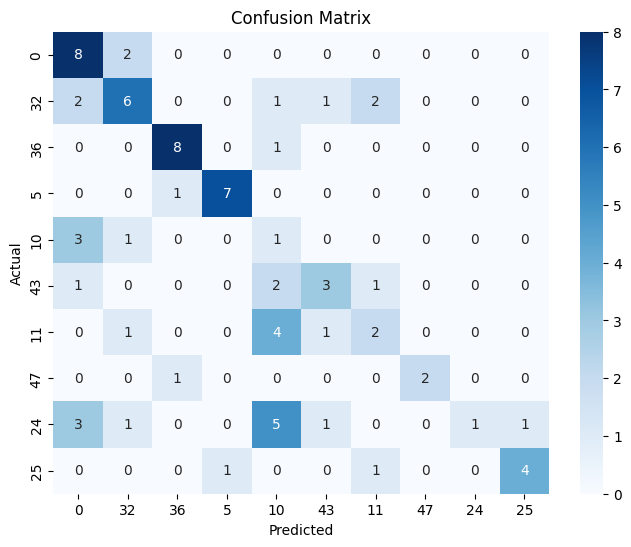

In [27]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_train), yticklabels=set(y_train))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()